# 1. Vanilla LSTEM model - Detailed

### We are here trying a vanilla LSTEM model for forecast

In [1]:
# List of all Parameters

# Timestamp of when we want to start the prediction
target_start = "8:00:00"

# n-1 minutes before the target date and n min after
time_variation = 30

## I. Loading libraries and the sample dataset

In [2]:
# Library Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit
import tensorflow as tf


from math import sqrt
from sklearn.metrics import mean_squared_error
from tensorflow.python.client import device_lib 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# To remove
#Activation

import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import pacf
from tensorflow import keras

Using TensorFlow backend.


In [3]:
# Is the computer running on GPU?
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9278463269862656973
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14800905681734869728
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
# Loading from github the dataset. It is an extract of the madeleine station only
start_time = timeit.default_timer()

df_station = pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")
df_station.head()

,Unnamed: 0,availiable_docks,date,weekday,hour
0,0,8,2020-01-15 10:17:00,Wednesday,10
1,1,8,2020-01-15 10:18:00,Wednesday,10
2,2,7,2020-01-15 10:19:00,Wednesday,10
3,3,8,2020-01-15 10:20:00,Wednesday,10
4,4,8,2020-01-15 10:21:00,Wednesday,10


## II. Preprocessing of the data

### A. Restraining the dataset over a time periode

### B. Creating the good format dataset

In [5]:
# Creating time_serie
df_conso = df_station
time_serie = df_conso["availiable_docks"]
print("Sample:",time_serie[0:10])

Sample: 0     8
1     8
2     7
3     8
4     8
5    10
6    11
7    12
8    12
9    16
Name: availiable_docks, dtype: int64


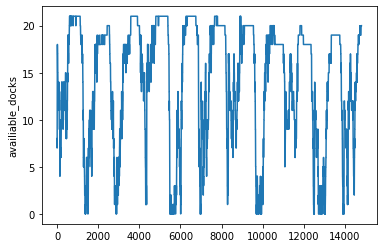

In [6]:
_ = sns.lineplot(data=df_conso, x=df_conso.index, y="availiable_docks")

### C. Train/Test Preprocessing

In [7]:
# Creation of variables

#Number of previous data
sequence_length=120
prediction_length=30

# repartition of the split
split=0.7

In [8]:
# Creating an array out of the dataset

df_array = np.array(time_serie).astype(float)
print(df_array)

[ 8.  8.  7. ... 20. 20. 20.]


In [9]:
# Preprocessing the data : using the MixMaxScaler from scikit learn
# Are other ones possibles?

scaler = MinMaxScaler()
df_array = scaler.fit_transform(df_array.reshape(1, -1))
df_array = df_array.reshape(-1, 1)
print(df_array)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [10]:
len(df_array.reshape(-1, 1))

14800

In [11]:
# creating data

data = []
for i in range(len(df_array) - sequence_length - 1):
    data.append(df_array[i: i + sequence_length + 1])

In [12]:
reshaped_data = np.array(data).astype('float64')

In [13]:
save_time = df_conso.date
# There is less time possible :
save_time_2 = save_time[:-(sequence_length+1)]
save_time_2.shape

(14679,)

In [15]:
#Not using it for further use with date
#np.random.shuffle(reshaped_data)
# 对x进行统一归一化，而y则不归一化
x = reshaped_data[:, :-prediction_length-1]
y = reshaped_data[:, -prediction_length:]
# La dernière donnée est scpée
split_boundary = int(reshaped_data.shape[0] * split)

train_x = x[: split_boundary]
test_x = x[split_boundary:]

train_y = y[: split_boundary]
test_y = y[split_boundary:]

train_time = save_time_2[: split_boundary]
test_time = save_time_2[split_boundary:]

In [16]:
x.shape

(14679, 90, 1)

In [17]:
y.shape

(14679, 30, 1)

In [18]:
train_x.reshape(1,-1)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [19]:
train_x.shape

(10275, 90, 1)

In [20]:
train_x.reshape(-1,1).shape

(924750, 1)

In [21]:
train_x.reshape(train_x.shape[0],train_x.shape[1])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
train_x.shape

(10275, 90, 1)

In [35]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(sequence_length - prediction_length, 1)))
model.add(RepeatVector(prediction_length))
#model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

In [31]:
model.fit(train_x, train_y, epochs=3) 

Epoch 1/3
10275/10275 [==============================] - 36s 4ms/step - loss: 0.0000e+00
Epoch 2/3
10275/10275 [==============================] - 37s 4ms/step - loss: 0.0000e+00
Epoch 3/3
10275/10275 [==============================] - 37s 4ms/step - loss: 0.0000e+00


In [22]:
X_input_scal=scaler.transform(array(raw_seq[-n_steps_in:]).reshape(-1,1))
X_input_scal.reshape(X_input_scal.shape[0],)
X_input_scal = X_input_scal.reshape((1, n_steps_in, n_features))
#x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(X_input_scal, verbose=0)
yhat=scaler.inverse_transform(yhat.reshape(yhat.shape[0],yhat.shape[1]))
elapsed = timeit.default_timer() - start_time
print(yhat)

NameError: name 'nsteps_in' is not defined

# Building the model

## MODEL B

In [ ]:
sequence_length=120
prediction_length=30

In [58]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(sequence_length - prediction_length, 1)))
model.add(RepeatVector(prediction_length))
#model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(train_x, train_y, batch_size=512, nb_epoch=30, validation_split=0.1)

In [59]:
model.fit(train_x, train_y, batch_size=512, nb_epoch=30, validation_split=0.1)

Train on 9247 samples, validate on 1028 samples
Epoch 1/30
9247/9247 [==============================] - 9s 1ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/30
9247/9247 [==============================] - 9s 920us/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/30
9247/9247 [==============================] - 8s 905us/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/30
9247/9247 [==============================] - 8s 916us/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/30
9247/9247 [==============================] - 8s 916us/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/30
9247/9247 [==============================] - 9s 925us/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/30
9247/9247 [==============================] - 9s 923us/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/30
9247/9247 [==============================] - 8s 912us/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/30
9247/9247 [==============================] - 8s

# Training the model

In [52]:
train_x.shape

(10275, 90, 1)

In [53]:
train_y.shape

(10275, 30, 1)

In [60]:
train_x.shape

(10275, 90, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
raw_seq = time_serie

# Supprimer

#normalisation
time_series_scaled = scaler.fit_transform((
#raw_seq_scaled = scaled_values.reshape(1,len(raw_seq_scaled)  )
# choose a number of time steps

In [ ]:
time_serie

In [ ]:
time_series_scaled.reshape(1,-1)

In [ ]:
nsteps_in, nsteps_out = 90, 30

X, y = split_sequence(time_series_scaled, nsteps_in, nsteps_out)

X=X.reshape(X.shape[0],X.shape[1])
y= y.reshape(y.shape[0],y.shape[1])
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
#model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=epok) # verbose=0)
# demonstrate prediction
#x_input = array(raw_seq[-n_steps_in:])
# Normalisation du "Test"
X_input_scal=scaler.transform(array(raw_seq[-n_steps_in:]).reshape(-1,1))
X_input_scal.reshape(X_input_scal.shape[0],)
X_input_scal = X_input_scal.reshape((1, n_steps_in, n_features))
#x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(X_input_scal, verbose=0)
yhat=scaler.inverse_transform(yhat.reshape(yhat.shape[0],yhat.shape[1]))
elapsed = timeit.default_timer() - start_time
print(yhat)

## III. Grid-searching the best ETS parameters

### A. Function definitions for proper grid-search

### B. Finding the best parameters over one periode

### C. Training on full time serie to optimize before prediction

## IV - Making the prediction up to the time variation and creating  assessment dataframe

In [ ]:
# Prediction the dataset + time variation
final_prediction = model.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))

# Creating a dataframe for assessement
df_assessement = pd.DataFrame(columns=["actual","forecast_first_run","forecast_optimized","forecast_optimized_round","backtest"])
# Setting actual at the last known value
df_assessement.actual = (np.concatenate((time_serie, (np.zeros(time_variation)+time_serie[-1:])), axis = 0))
# Setting forecast at time_serie for the past and the final prediction for the futur
df_assessement.forecast_first_run = (np.concatenate((train, pred_first_run, (np.zeros(time_variation)+pred_first_run[-1:])), axis = 0))
df_assessement.forecast_optimized = (np.concatenate((time_serie, final_prediction), axis = 0))
df_assessement.forecast_optimized_round = df_assessement.forecast_optimized.apply(lambda x:round(x,0))
df_assessement.backtest = (np.concatenate((time_serie, df_backtest), axis = 0))
df_assessement["date"] = df_conso["date"]
df_assessement.head()

In [ ]:
# Making a synthetic dataset for easier visualisation

df_assessement_small = df_assessement[-time_variation*2:]
start_date = pd.Timestamp(np.array(df_assessement_small["date"])[0])
end_date = start_date + pd.Timedelta(minutes=time_variation*2-1)

print("Start time:",start_date)
print("End time:", end_date)

index_date = pd.date_range(start=start_date, end=end_date, freq="T")
df_assessement_small.index = index_date
df_assessement_small.pop("date")
df_assessement_small["day_before"] = np.array(df_assessement[-time_variation*4:-time_variation*2]["actual"])
df_assessement_small.head()

## V - Graphic Prediction

### A. Graphic Prepration

In [ ]:
# Function that return the minimum and maximum value of a dataframe

def upper_lower_bounds(dataframe):
    min_value = 999
    max_value= 0
    for i in dataframe.columns:
        temp_list = np.array(dataframe[i])
        temp_list = temp_list[temp_list >= 0]
        min_temp = np.amin(temp_list)
        max_temp = np.amax(temp_list)
        if min_temp < min_value:
            min_value=min_temp
        if max_temp > max_value:
            max_value = max_temp
    return(max_value, min_value)

In [ ]:
# Calculating lower and upper bounds for ulterior use

lower_bound, upper_bound = upper_lower_bounds(df_assessement_small)

### B. Full Prediction

In [ ]:
# Graphic visualisation of the prediction

#Removing actual and backtest data on projection time for better visualisation
df_assessement.actual[-time_variation:] = None
df_assessement.backtest[:-time_variation+1] = None

fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x=df_assessement.index, y="forecast_optimized",data=df_assessement, color="blue")
sns.lineplot(x=df_assessement.index, y="forecast_optimized_round",data=df_assessement, color="cyan")
sns.lineplot(x=df_assessement.index, y="forecast_first_run",data=df_assessement, color="yellow")
sns.lineplot(x=df_assessement.index, y="backtest",data=df_assessement, color="red")
sns.lineplot(x=df_assessement.index, y="actual",data=df_assessement, color="green")

plt.show()

## VI - Synthesis

In [ ]:
# Setting prediction boundary


#Removing actual and backtest data on projection time for better visualisation
df_assessement_small.actual[-time_variation:] = None
df_assessement_small.backtest[:-time_variation-1] = None

# Graphic visualisation of the prediction
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized",data=df_assessement_small, color="blue",label="Forecast")
ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized_round",data=df_assessement_small, color="cyan",label="Quantized Forecast")
ax = sns.lineplot(x=df_assessement_small.index, y="day_before",data=df_assessement_small, color="#003300",label="Yesterday")
ax = sns.lineplot(x=df_assessement_small.index, y="actual",data=df_assessement_small, color="green",label="Today")
ax = sns.lineplot(x=df_assessement_small.index, y="backtest",data=df_assessement_small, color="red",label="Backtest")

x1, y1 = [df_assessement_small.index[time_variation]-1, df_assessement_small.index[time_variation]-1], [lower_bound, upper_bound]
ax = plt.plot(x1, y1, linestyle="dashdot", color="red")


plt.show()

In [ ]:
# Time to run

elapsed = timeit.default_timer() - start_time
print("Executation time" , int(elapsed/60), "min", int((round(elapsed/60,2,)-(int(elapsed/60)))*60), "s")


# RMSE for assessement

rmse_f_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized[time_variation:])
rmse_rf_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized_round[time_variation:])
print("RMSE forecast vs backtest:", rmse_f_b)
print("RMSE round forecast vs backtest:", rmse_rf_b)

#reminder of best parameters
print("Best parameters for SARIMA model:",best_parameters)